# Drone Model-Predictive Control

## Package Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

from pydrake.all import (
    AddMultibodyPlantSceneGraph, DiagramBuilder,DirectCollocation, DirectTranscription,
    FiniteHorizonLinearQuadraticRegulatorOptions, FindResourceOrThrow, LinearSystem, Linearize,
    LogVectorOutput, MultibodyPlant, MakeFiniteHorizonLinearQuadraticRegulator,
    MathematicalProgram, MeshcatVisualizerParams, MeshcatVisualizerCpp, Parser, 
    plot_system_graphviz, Propeller, PropellerInfo, PiecewisePolynomial, RandomSource, RandomDistribution, 
    RigidTransform, Role, RotationMatrix, SceneGraph, Simulator, Solve, StartMeshcat, 
    TrajectorySource, Trajectory, TimeStep, VectorSystem )

from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController)

from underactuated.meshcat_cpp_utils import MeshcatSliders

#from pydrake.multibody.plant import Wing





In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://252d90d3-1ad4-4a56-8b32-ebf5b097846b.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


## Define obstacle class &amp; Sim environment class

In [3]:
class Obstacle():

    def __init__(self, sdf, p, body_name):

        self.sdf = sdf
        self.position = p
        self.body_name = body_name


    #parse sdf file to instantiate object and weld it to the simulation world
    def connect_obstacle_to_world(self, obstacle_plant, scene_graph):

        parser = Parser(obstacle_plant, scene_graph)

        self.model_instance = parser.AddModelFromFile(self.sdf)
        self.body = obstacle_plant.GetBodyByName(self.body_name, self.model_instance)
        obstacle_plant.WeldFrames(obstacle_plant.world_frame(), self.body.body_frame(), RigidTransform(p=self.position))

    # calculate 3D distance vector from quadrotor to object
    # quad_state parameter is truncated version of full state [x,y,z]
    def distance_from_object(self, quad_state):
        return quad_state - self.position


class SimEnvironment:

    def __init__(self):
            #define diagram builder, used to connect plant and controller inputs / outputs
            self.builder = DiagramBuilder()

            #add plant, scene graph to builder
            self.obstacle_plant, self.scene_graph = AddMultibodyPlantSceneGraph(self.builder, time_step = 1.0)

            self.quadrotor_plant = self.builder.AddSystem(QuadrotorPlant())

            self.controller = self.builder.AddSystem(StabilizingLQRController(self.quadrotor_plant, [0.5,0, 0.5]))

    def setup_obstacles(self):

        self.obstacles = []

        self.obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[0.5, 0.6, 0.7],"tree_body"))
        self.obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[2, 1, 0.5], "tree_body"))
        self.obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[2, 3, 0.5], "tree_body"))
        
        for obs in self.obstacles:
            obs.connect_obstacle_to_world(self.obstacle_plant, self.scene_graph)
        

    def connect_systems(self):
        self.builder.Connect(self.controller.get_output_port(0), self.quadrotor_plant.get_input_port(0))
        self.builder.Connect(self.quadrotor_plant.get_output_port(0), self.controller.get_input_port(0))

    def setup_visualization(self):

        global meshcat

        # Set up visualization in MeshCat

        self.quad_geometry = QuadrotorGeometry.AddToBuilder(self.builder, self.quadrotor_plant.get_output_port(0), self.scene_graph)
        meshcat.Delete()
        meshcat.ResetRenderMode()
        meshcat.SetProperty('/Background','visible',False)
        # Add visualizer to visualize the geometries.
        self.visualizer = MeshcatVisualizerCpp.AddToBuilder(self.builder, self.scene_graph, meshcat,
            MeshcatVisualizerParams(role=Role.kPerception, prefix="visual"))

            
        # add collision visualizer
        #collision = MeshcatVisualizerCpp.AddToBuilder(
        #    builder, scene_graph, meshcat,
        #    MeshcatVisualizerParams(role=Role.kProximity, prefix="collision"))

        #meshcat.SetProperty("collision", "visible", True)
        # end setup for visualization

    def build_block_diagram(self):
        self.diagram = self.builder.Build()
        ############### Visualize 
        # give names to the blocks (just to make the plot nicer)
        self.diagram.set_name('Block Diagram for Quadrotor control')
        self.quadrotor_plant.set_name('Quadrotor Plant')
        self.quad_geometry.set_name("Quadrotor Geometry")
        self.controller.set_name('Stabilizing LQR Controller')
        self.scene_graph.set_name('Scene Graph')
        self.visualizer.set_name('Visualizer')

        # plot current diagram
        plt.figure(figsize=(20, 10))
        plot_system_graphviz(self.diagram)


    def run_sim(self):

        global meshcat
        
        # Set up a simulator to run this diagram
        simulator = Simulator(diagram)
        context = simulator.get_mutable_context()


        #continuous_state = context.get_mutable_continuous_state_vector()

        # Set the initial conditions (theta1, theta2, theta1dot, theta2dot)
        context.SetContinuousState([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

        # print(f"continuous state {continuous_state}")
        #print(f"size of continuous state {continuous_state.size()}")
        simulator.set_target_realtime_rate(0.5)
        meshcat.AddButton('Stop Simulation')
        while meshcat.GetButtonClicks('Stop Simulation') < 1:
            
            simulator.AdvanceTo(simulator.get_context().get_time() + 0.1)

        meshcat.DeleteAddedControls()



## Non-Linear Trajectory Optimization for the Quadrotor

Find an optimal trajectory from an initial condition to a target destination, that minimizes time to target destination, and adheres to thrust limits

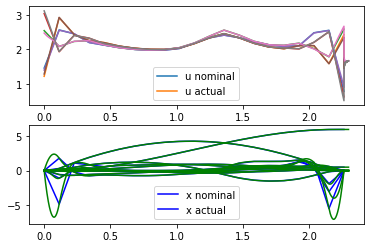

None

In [8]:
class QuadrotorTrajOpt():

    def __init__(self, init_state, target_state, num_time_samples, thrust_limit):
        self.init_state = init_state
        self.target_state = target_state
        self.num_time_samples = num_time_samples
        self.thrust_limit = thrust_limit

    def dir_col_opt(self, quadrotor_plant, quadrotor_context, obstacle_list):

        # use direct collocation to integrate quadrotor dynamics
        # DirectCollation classe performs Direct transcription trajectory optimization using nonlinear programming and collocation
        # It assumes a first-order hold on the input trajectory and a cubic spline representation of the state trajectory, and adds dynamic constraints 
        # (and running costs) to the midpoints as well as the breakpoints in order to achieve a 3rd order integration accuracy.
        dircol = DirectCollocation(quadrotor_plant,
                                quadrotor_context,
                                num_time_samples=self.num_time_samples,
                                minimum_timestep=0.05,
                                maximum_timestep=0.2)

        #Returns a reference to the MathematicalProgram associated with the trajectory optimization problem.
        prog = dircol.prog()

        # add constraint that enforces that all timesteps have equal duration (ensures more efficient optimization)
        dircol.AddEqualTimeIntervalsConstraints()

        # Returns placeholder decision variables (not actually declared as decision variables in the MathematicalProgram) 
        # associated with the input, u, but with the time-index undetermined.
        u = dircol.input()

        x = dircol.state()

        #print(f"state = {x}")
        #print(f"input = {u}")

        #TODO: contrain roll, pitch & yaw to be below 90

        # enforce collision avoidance constraints for each obstacle

        for obs in obstacle_list:
            # pass [x,y,z] position of quadrotor to get distance vector 
            quad_state_xyz = x[:3]
            distance_vector = obs.distance_from_object(quad_state_xyz)
            #x distance from center of object
            dircol.AddConstraintToAllKnotPoints(np.linalg.norm(distance_vector) >= 1.0 )
        
        #enforce constraint that drone cannot fly underground
        dircol.AddConstraintToAllKnotPoints(x[2]>= 0)

        #enforce constraint drone cannot fly above tree line
        #dircol.AddConstraintToAllKnotPoints(x[2]<= 3)

        # enforce individual thrust limits for each propellor
        dircol.AddConstraintToAllKnotPoints(u[0] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[0])

        dircol.AddConstraintToAllKnotPoints(u[1] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[1])

        dircol.AddConstraintToAllKnotPoints(u[2] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[2])

        dircol.AddConstraintToAllKnotPoints(u[3] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[3])

        # add initial state constraint (first parameter is upper bound, second parameter is lower bound, 3rd parameter is variable being constrained)
        prog.AddBoundingBoxConstraint(self.init_state, self.init_state,
                                    dircol.initial_state())

        # add final state constraint
        prog.AddBoundingBoxConstraint(self.target_state, self.target_state,
                                    dircol.final_state())


        R = 100  # Cost on input "effort".
        dircol.AddRunningCost(R * u[0]**2)
        dircol.AddRunningCost(R * u[1]**2)
        dircol.AddRunningCost(R * u[2]**2)
        dircol.AddRunningCost(R * u[3]**2)

        # Add a final cost equal to the total duration.
        dircol.AddFinalCost(dircol.time())

        # Construct an initial guess at an optimal trajectory
        # PiecewisePolynomial.FirstOrderHold Constructs a piecewise linear PiecewisePolynomial using matrix samples.
        breaks = [0., 4.]
        samples = np.column_stack((self.init_state, self.target_state))
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(breaks, samples)  # yapf: disable

        dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

        result = Solve(prog)
        assert (result.is_success())

        u_trajectory = dircol.ReconstructInputTrajectory(result)
        x_trajectory = dircol.ReconstructStateTrajectory(result)

        return u_trajectory, x_trajectory

    def create_lqr_stabilizer(self, x_trajectory, u_trajectory, quadrotor_plant, quadrotor_context):
        options = FiniteHorizonLinearQuadraticRegulatorOptions()
        options.x0 = x_trajectory
        options.u0 = u_trajectory
        
        #define state penalty matrix with a 10 to 1 ratio on positions vs velocites
        #[x,y,z,roll,pitch,yaw, xdot, ydot, zdot, rolldot, pitchdot, yawdot]
        Q = np.diag([10.,10.,10.,10.,10.,10.,1.,1.,1.,1.,1.,1.])

        #final cost matrix
        options.Qf = Q
        # there are 4 thrust inputs, add minimum penalty to thrust
        R = np.eye(4)

        lqr_regulator = MakeFiniteHorizonLinearQuadraticRegulator(quadrotor_plant,
                                                  quadrotor_context,
                                                  t0=options.u0.start_time(),
                                                  tf=options.u0.end_time(),
                                                  Q=Q,
                                                  R=R,
                                                  options=options)
        return lqr_regulator, options

    def linear_continous_dynamics(self, quadrotor_plant, quadrotor_mutable_context):
        input_port = quadrotor_plant.get_input_port(0)
        output_port = quadrotor_plant.get_output_port(0)
        eq_check_tolerance = 10e6 # we do not need to be at an equilibrium point
        cont_linear_quadrotor = Linearize(quadrotor_plant, quadrotor_context, \
        input_port.get_index(), output_port.get_index(),eq_check_tolerance )

        return cont_linear_quadrotor
        

    def discrete_dynamics(self):
        pass

    def linear_mpc(self, quadrotor_plant, quadrotor_mutable_context, obstacle_list):
        ##################
        # Linearize system dynamics - Take first order taylor series expansions of system
        # around the operating point defined by quadrotor mutable context
        ##################
        linear_quadrotor = self.linear_continous_dynamics(quadrotor_plant, quadrotor_mutable_context)
        
        ###################
        # Define optimization solver and contstraints
        ####################
        # must pass time step parameter to direct transcription class, so it knows that it is working
        # with a continous system input, and will perform euler intergration to define dynamics
        # constraints
        time_step = TimeStep(0.1)
        dirtran = DirectTranscription(linear_quadrotor, quadrotor_mutable_context,self.num_time_samples, time_step)

        #Returns a reference to the MathematicalProgram associated with the trajectory optimization problem.
        prog = dirtran.prog()

        u = dirtran.input()
        x = dirtran.state()

        # enforce individual thrust limits for each propellor
        # dirtran.AddConstraintToAllKnotPoints(u[0] <= self.thrust_limit)
        # dirtran.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[0])

        # dirtran.AddConstraintToAllKnotPoints(u[1] <= self.thrust_limit)
        # dirtran.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[1])

        # dirtran.AddConstraintToAllKnotPoints(u[2] <= self.thrust_limit)
        # dirtran.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[2])

        # dirtran.AddConstraintToAllKnotPoints(u[3] <= self.thrust_limit)
        # dirtran.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[3])

        # add initial state constraint (first parameter is upper bound, second parameter is lower bound, 3rd parameter is variable being constrained)
        prog.AddBoundingBoxConstraint(self.init_state, self.init_state,
                                    dirtran.initial_state())

        # add final state constraint
        prog.AddBoundingBoxConstraint(self.target_state, self.target_state,
                                    dirtran.final_state())

        R = 100  # Cost on input "effort".
        dirtran.AddRunningCost(R * u[0]**2)
        dirtran.AddRunningCost(R * u[1]**2)
        dirtran.AddRunningCost(R * u[2]**2)
        dirtran.AddRunningCost(R * u[3]**2)

        # Add a final cost equal to the total duration.
        dirtran.AddFinalCost(dirtran.time())

        # Construct an initial guess at an optimal trajectory
        # PiecewisePolynomial.FirstOrderHold Constructs a piecewise linear PiecewisePolynomial using matrix samples.
        breaks = [0., 4.]
        samples = np.column_stack((self.init_state, self.target_state))
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(breaks, samples)  # yapf: disable

        dirtran.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

        ###################
        # Solve optimization
        ####################

        result = Solve(prog)
        assert (result.is_success())

        u_trajectory = dirtran.ReconstructInputTrajectory(result)
        x_trajectory = dirtran.ReconstructStateTrajectory(result)

        return u_trajectory, x_trajectory


#calculate optimal trajectory and simulation
initial_state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# target state for trajectory optimization
final_state = [0, 6, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# limit of thrust force for each individual propellor
thrust_limit = 5.0
#we want to have an odd number
num_time_samples = 21


builder = DiagramBuilder()

quad_traj_opt = QuadrotorTrajOpt(initial_state, final_state, num_time_samples, thrust_limit)

world_plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 1.0)

obstacles = []

obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[2, 2, 0.5],"tree_body"))
obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[-2, 2, 0.5], "tree_body"))
obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[0, 4, 0.5], "tree_body"))

for obs in obstacles:
    obs.connect_obstacle_to_world(world_plant, scene_graph)


world_plant.Finalize()


quadrotor_plant = QuadrotorPlant()
quadrotor_context = quadrotor_plant.CreateDefaultContext()
# quadrotor_plant = builder.AddSystem(quadrotor_plant)

u_trajectory, x_trajectory = quad_traj_opt.dir_col_opt(quadrotor_plant, quadrotor_context, obstacles)
lqr_regulator, options = quad_traj_opt.create_lqr_stabilizer(x_trajectory, u_trajectory, quadrotor_plant, quadrotor_context)
lqr_regulator = builder.AddSystem(lqr_regulator)
quadrotor_plant = builder.AddSystem(quadrotor_plant)
end_time = options.u0.end_time()
builder.Connect(lqr_regulator.get_output_port(0), quadrotor_plant.get_input_port(0))
builder.Connect(quadrotor_plant.get_output_port(0), lqr_regulator.get_input_port(0))
input_logger = LogVectorOutput(lqr_regulator.get_output_port(0), builder)
state_logger = LogVectorOutput(quadrotor_plant.get_output_port(0), builder)

        

# Set up visualization in MeshCat
QuadrotorGeometry.AddToBuilder(builder, quadrotor_plant.get_output_port(0), scene_graph)
meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty('/Background','visible',False)
MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
# end setup for visualization

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()
sim_context.SetContinuousState(initial_state)

####################### needed to test mpc ############################
# quadrotor_mutable_context = quadrotor_plant.GetMyMutableContextFromRoot(sim_context)
# quadrotor_plant.get_input_port(0).FixValue(quadrotor_context, [0,0,0,0])

# # quad_traj_opt.linear_mpc(quadrotor_plant, quadrotor_context, obstacles)

simulator.set_target_realtime_rate(1.0)
meshcat.AddButton('Stop Simulation')
while simulator.get_context().get_time() < end_time:

    simulator.AdvanceTo(simulator.get_context().get_time() + 0.1)

meshcat.DeleteAddedControls()

fig, ax = plt.subplots(2,1)
ax[0].plot(options.u0.get_segment_times(),
            options.u0.vector_values(options.u0.get_segment_times()).T)
input_log = input_logger.FindLog(simulator.get_context())
ax[0].plot(input_log.sample_times(), input_log.data().T)
ax[0].legend(('u nominal','u actual'))

ax[1].plot(options.x0.get_segment_times(),
            options.x0.vector_values(options.x0.get_segment_times()).T, 'b')
state_log = state_logger.FindLog(simulator.get_context())
ax[1].plot(state_log.sample_times(), state_log.data().T, 'g')
ax[1].legend(('x nominal','x actual'))
display(plt.show())





    


## Setup Environment and Run Simulation

In [5]:
# ###### Initialization of plants and controllers to be added to diagram builder #############

# #define diagram builder, used to connect plant and controller inputs / outputs

# builder = DiagramBuilder()

# #add plant, scene graph to builder

# obstacle_plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 1.0)

# quadrotor_plant = builder.AddSystem(QuadrotorPlant())

# controller = builder.AddSystem(StabilizingLQRController(quadrotor_plant, [0.5,0, 0.5]))

# #quad_body = quadrotor_plant.GetBodyByName("quadrotor")

# #wing = Wing()


# ############ Setup Obstacles #################

# obstacles = []

# obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[0.5, 0.6, 0.7],"tree_body"))
# obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[2, 1, 0.5], "tree_body"))
# obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[2, 3, 0.5], "tree_body"))

# for obs in obstacles:
#     obs.connect_obstacle_to_world(obstacle_plant, scene_graph)

# obstacle_plant.Finalize()


# ########## Connect components of block diagram ##########

# builder.Connect(controller.get_output_port(0), quadrotor_plant.get_input_port(0))
# builder.Connect(quadrotor_plant.get_output_port(0), controller.get_input_port(0))



# ############### Setup Visualization #################


# # Set up visualization in MeshCat

# quad_geometry = QuadrotorGeometry.AddToBuilder(builder, quadrotor_plant.get_output_port(0), scene_graph)
# meshcat.Delete()
# meshcat.ResetRenderMode()
# meshcat.SetProperty('/Background','visible',False)
# # Add visualizer to visualize the geometries.
# visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat,
#     MeshcatVisualizerParams(role=Role.kPerception, prefix="visual"))

    
# # add collision visualizer
# #collision = MeshcatVisualizerCpp.AddToBuilder(
# #    builder, scene_graph, meshcat,
# #    MeshcatVisualizerParams(role=Role.kProximity, prefix="collision"))

# #meshcat.SetProperty("collision", "visible", True)
# # end setup for visualization



# ################ Build block diagram and visualiz ####################
# diagram = builder.Build()
# ############### Visualize 
# # give names to the blocks (just to make the plot nicer)
# diagram.set_name('Block Diagram for Quadrotor control')
# quadrotor_plant.set_name('Quadrotor Plant')
# quad_geometry.set_name("Quadrotor Geometry")
# controller.set_name('Stabilizing LQR Controller')
# scene_graph.set_name('Scene Graph')
# visualizer.set_name('Visualizer')

# # plot current diagram
# plt.figure(figsize=(20, 10))
# plot_system_graphviz(diagram)


# ########## Run Simulation ##################


# # Set up a simulator to run this diagram
# simulator = Simulator(diagram)
# context = simulator.get_mutable_context()


# #continuous_state = context.get_mutable_continuous_state_vector()

# # Set the initial conditions (theta1, theta2, theta1dot, theta2dot)
# context.SetContinuousState([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# # print(f"continuous state {continuous_state}")
# #print(f"size of continuous state {continuous_state.size()}")
# simulator.set_target_realtime_rate(0.5)
# meshcat.AddButton('Stop Simulation')
# while meshcat.GetButtonClicks('Stop Simulation') < 1:
    
#     simulator.AdvanceTo(simulator.get_context().get_time() + 0.1)

# meshcat.DeleteAddedControls()

## Wind Turbulence Model 

A standard mathematical model used to approximate continuous wind gusts is the Dryden Wind Turbulence Model.

altitude in region 3: > 2000 ft
sigma_u = 15.6, L_u = 1750
sigma_v = 15.6, L_v = 1750 
sigma_w = 15.6, L_w = 1750 
vehicle_speed = 5


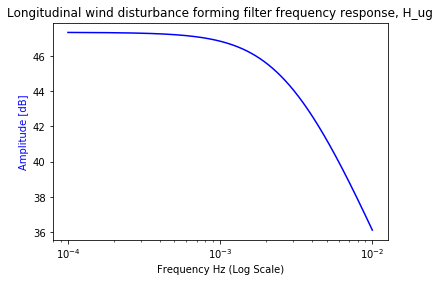

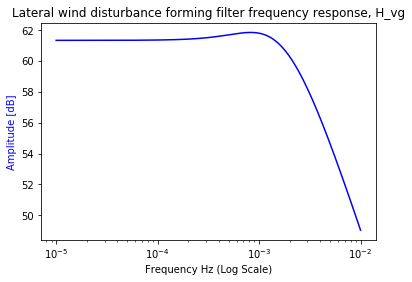

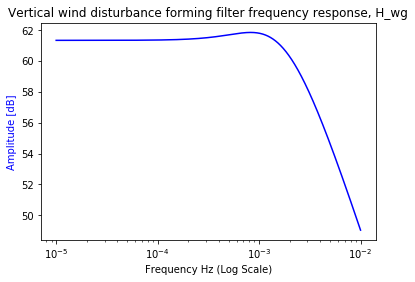

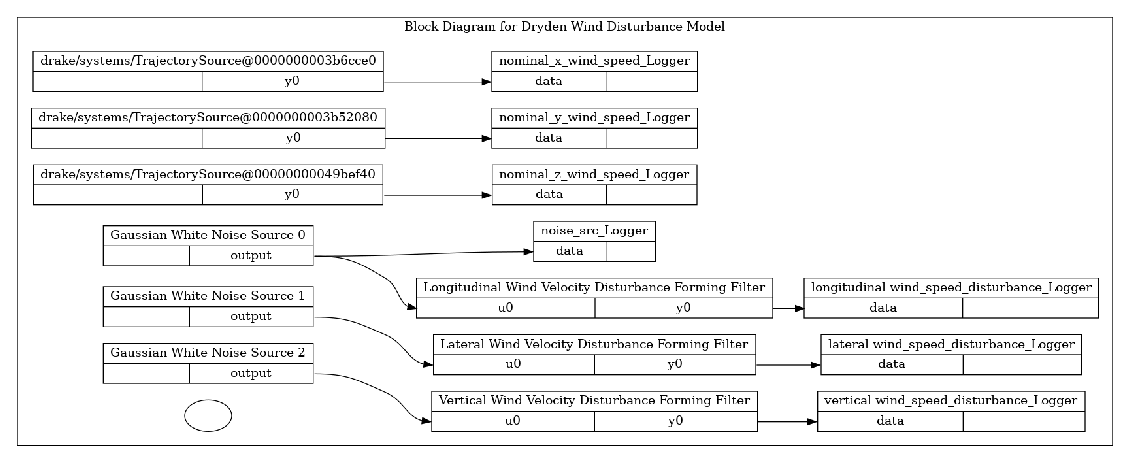

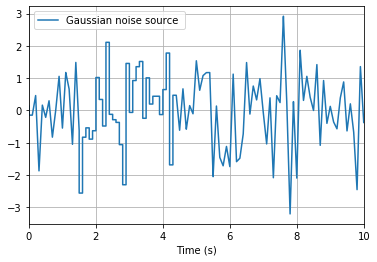

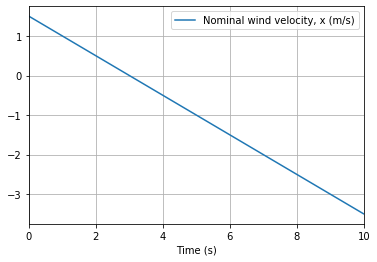

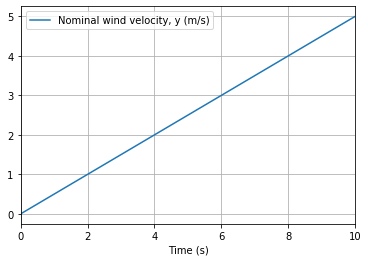

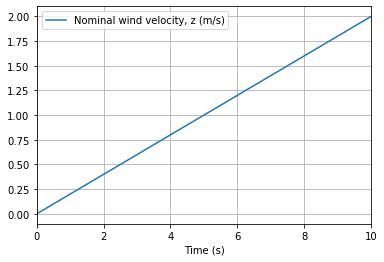

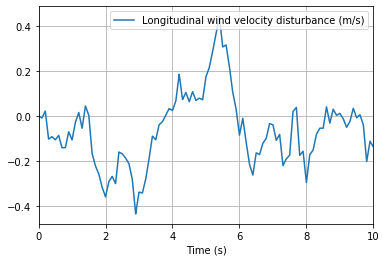

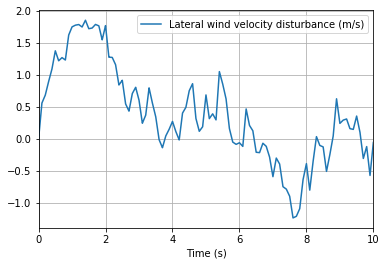

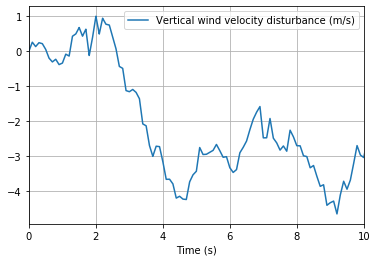

In [6]:
# the dryden noise class 
fig_num = 0;

class DrydenWindDisturbance:

    '''Generate colored noise used to represent wind turbulence using the Dryden Wind Disturbance Model.'''

    def __init__(self, sampling_interval):

        # define the number of outputs for the gaussian noise source used to generate 
        # Dryden wind disturbance
        self.sampling_interval = sampling_interval

    def calculate_model_parameters(self, altitude, wind_speed):
        #########################
        # turbulence intensities( sigma_u, sigma_v, sigma_w), and turbulence lengths (L_u, L_v, L_w) are 
        # functions of altitude h, divided into three regions:
        #
        # wind_speed = 15 knots for light turbulence, 30 knots for moderate turbulence, 
        # 45 knots for severe turbulence
        #
        # units of altitude in ft



        ######################## Region 1: altitude < 1000
        if (altitude < 1000):

            sigma_w = 0.1 * wind_speed
            
            sigma_v  = sigma_w / ( (0.177 + 0.000823* altitude) ** 0.4 )

            sigma_u = sigma_v

            L_w = altitude

            L_v = altitude / ( (0.177 + 0.000823* altitude) ** 1.2 )

            L_u = L_v

        ######################### Region 2: 1000 < altitude < 2000
        # Calculated be performing linear interpolation between regions 1 & 3

        elif (1000 <= altitude <= 2000):
            print("altitude in region 2: 1000 - 2000 ft, not implemented")
            # typically implemented as linear interpolation between parameter values in high altitude region 
            # and parameter values in the low altitude region
            # not implemented, as this project is only concerned with high altitude region

        ######################### Region 3: altitude > 2000
        else:
            print("altitude in region 3: > 2000 ft")
            # in this region, turbulence is assumed isotropic, which leads to turbulence scale length to be constant
            L_u = L_v = L_w = 1750

            # typically sigma_u, sigma_v, and sigma_w are represented with a lookup table, but here 
            # they will be approximated with formulas

            # we are in light turbelence regime, wind speed in knots
            if wind_speed <= 15:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.000375) + 6
                if (altitude > 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.00025) + 8.5
            # medium turbulence
            elif 15 < wind_speed <= 45:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.000875) + 7.5
                if (altitude > 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.0001935) + 11.774
            # high turbulence, wind_speed > 45
            else:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.0002) + 15
                if (4000 <altitude < 8000 ):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.00009375) + 22.625
                if (altitude >= 8000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.000221) + 25.515

        return sigma_u, sigma_v, sigma_w, L_u, L_v, L_w

    
    def ug_filter(self, sigma_u, L_u, vehicle_speed):

        global fig_num

        # H_ug(s) = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed)) * (1 / (1 + L_u/V s))

        # define gain for transfer function that will produce PSD of the linear wind velocity in direction u)
        H_ug_gain = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed))
        #print(f"H_ug_gain = {H_ug_gain}")
        
        #define lowpass filter that will produce longitudinal linear wind disturbance
        # highest order terms are first in the array

        H_ug_tf = signal.TransferFunction(H_ug_gain, [ L_u / vehicle_speed, 1] )

        #print(H_ug_tf)

        w, H = signal.freqresp(H_ug_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Longitudinal wind disturbance forming filter frequency response, H_ug')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        #plt.xlabel('Frequency [rad/sec]')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_ug_ss = H_ug_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_ug_sys = LinearSystem(H_ug_ss.A, H_ug_ss.B, H_ug_ss.C, H_ug_ss.D )

        return self.H_ug_sys

    def vg_filter(self, sigma_v, L_v, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_vg_gain = sigma_v * np.sqrt(2* L_v / np.pi * vehicle_speed)
        
        #print(f"H_vg_gain = {H_vg_gain}")

        # highest order terms are first in the array
        H_vg_tf = signal.TransferFunction([(H_vg_gain * 2 * np.sqrt(3) * L_v / vehicle_speed ), H_vg_gain ], \
        [(2*L_v/vehicle_speed)**2, 4*L_v/vehicle_speed, 1] )

        #print(H_vg_tf)

        w, H = signal.freqresp(H_vg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Lateral wind disturbance forming filter frequency response, H_vg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_vg_ss = H_vg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_vg_sys = LinearSystem(H_vg_ss.A, H_vg_ss.B, H_vg_ss.C, H_vg_ss.D )

        return self.H_vg_sys

    def wg_filter(self, sigma_w, L_w, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_wg_gain = sigma_w * np.sqrt(2* L_w / np.pi * vehicle_speed)
        
        #print(f"H_wg_gain = {H_wg_gain}")

        # highest order terms are first in the array
        H_wg_tf = signal.TransferFunction([(H_wg_gain * 2 * np.sqrt(3) * L_w / vehicle_speed ), H_wg_gain ], \
        [(2*L_w/vehicle_speed)**2, 4*L_w/vehicle_speed, 1] )

        #print(H_wg_tf)

        w, H = signal.freqresp(H_wg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Vertical wind disturbance forming filter frequency response, H_wg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_wg_ss = H_wg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_wg_sys = LinearSystem(H_wg_ss.A, H_wg_ss.B, H_wg_ss.C, H_wg_ss.D )

        return self.H_wg_sys


    

    def connect_Dryden_noise_src(self, builder):

        # define gaussiang random noise input
        gaussian_distribution = RandomDistribution(1) # parameter of 1 = gaussian distribution
        self.white_noise_src0 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src1 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src2 = RandomSource(gaussian_distribution, 1, self.sampling_interval)


        builder.AddSystem(self.white_noise_src0)
        builder.AddSystem(self.white_noise_src1)
        builder.AddSystem(self.white_noise_src2)

        builder.AddSystem(self.H_ug_sys)
        builder.AddSystem(self.H_vg_sys)
        builder.AddSystem(self.H_wg_sys)


        builder.Connect(self.white_noise_src0.get_output_port(0), self.H_ug_sys.get_input_port(0))
        builder.Connect(self.white_noise_src1.get_output_port(0), self.H_vg_sys.get_input_port(0))
        builder.Connect(self.white_noise_src2.get_output_port(0), self.H_wg_sys.get_input_port(0))


        self.white_noise_src0.set_name("Gaussian White Noise Source 0")
        self.white_noise_src1.set_name("Gaussian White Noise Source 1")
        self.white_noise_src2.set_name("Gaussian White Noise Source 2")


        self.H_ug_sys.set_name("Longitudinal Wind Velocity Disturbance Forming Filter")
        self.H_vg_sys.set_name("Lateral Wind Velocity Disturbance Forming Filter")
        self.H_wg_sys.set_name("Vertical Wind Velocity Disturbance Forming Filter")

        return [self.white_noise_src0, self.white_noise_src1, self.white_noise_src2]


# simulation time
sim_time = 10
time_step = 0.1

num_time_steps = int(sim_time / time_step)


sampling_interval = 0.1 # seconds
altitude = 3000 #ft
wind_speed = 50 # knots (worst case parameters)
vehicle_speed = 5 # m/s (specify worst case parameters)

dryden_noise = DrydenWindDisturbance(sampling_interval)

### Calculate Dryden model parameters
sigma_u, sigma_v, sigma_w, L_u, L_v, L_w = dryden_noise.calculate_model_parameters(altitude, wind_speed)

print(f"sigma_u = {sigma_u}, L_u = {L_u}") 
print(f"sigma_v = {sigma_v}, L_v = {L_v} ")
print(f"sigma_w = {sigma_w}, L_w = {L_w} ")
print(f"vehicle_speed = {vehicle_speed}")

##################################################################################
####### define the linear systems used to model wind velocity disturbances in each direction 
##################################################################################
H_ug_sys = dryden_noise.ug_filter(sigma_u, L_u, vehicle_speed)
H_vg_sys = dryden_noise.vg_filter(sigma_v, L_v, vehicle_speed)
H_wg_sys = dryden_noise.wg_filter(sigma_w, L_w, vehicle_speed)


##################################################################################
####### define nominal velocity trajectory in X, Y, and Z directions #############
##################################################################################
breaks = [0, sim_time]
init_x_velocity = [1.5]
final_x_velocity = [-3.5]
init_y_velocity = [0.0]
final_y_velocity = [5.0]
init_z_velocity = [0.0]
final_z_velocity = [2.0]
x_samples = np.column_stack((init_x_velocity, final_x_velocity))
y_samples = np.column_stack((init_y_velocity, final_y_velocity))
z_samples = np.column_stack((init_z_velocity, final_z_velocity))
wind_vel_x_traj = PiecewisePolynomial.FirstOrderHold(breaks, x_samples)
wind_vel_y_traj = PiecewisePolynomial.FirstOrderHold(breaks, y_samples)
wind_vel_z_traj = PiecewisePolynomial.FirstOrderHold(breaks, z_samples)



builder = DiagramBuilder()



nom_wind_x_source = builder.AddSystem(TrajectorySource(wind_vel_x_traj))
nom_wind_y_source = builder.AddSystem(TrajectorySource(wind_vel_y_traj))
nom_wind_z_source = builder.AddSystem(TrajectorySource(wind_vel_z_traj))

logger_x = LogVectorOutput(nom_wind_x_source.get_output_port(), builder)
logger_x.set_name('nominal_x_wind_speed_Logger')
logger_y = LogVectorOutput(nom_wind_y_source.get_output_port(), builder)
logger_y.set_name('nominal_y_wind_speed_Logger')
logger_z = LogVectorOutput(nom_wind_z_source.get_output_port(), builder)
logger_z.set_name('nominal_z_wind_speed_Logger')



##################################################################################
####### Connect noise Dryden noise generators #############
##################################################################################

[white_noise_src0, white_noise_src1, white_noise_src2]  = dryden_noise.connect_Dryden_noise_src(builder)

# logger that records the state trajectory during simulation
logger_ug = LogVectorOutput(H_ug_sys.get_output_port(), builder)
logger_ug.set_name('longitudinal wind_speed_disturbance_Logger')
logger_vg = LogVectorOutput(H_vg_sys.get_output_port(), builder)
logger_vg.set_name('lateral wind_speed_disturbance_Logger')
logger_wg = LogVectorOutput(H_wg_sys.get_output_port(), builder)
logger_wg.set_name('vertical wind_speed_disturbance_Logger')


# logger that records the state trajectory during simulation
logger_noise = LogVectorOutput(white_noise_src0.get_output_port(), builder)
logger_noise.set_name('noise_src_Logger')

diagram = builder.Build()

############### Visualize 
# give names to the blocks (just to make the plot nicer)
diagram.set_name('Block Diagram for Dryden Wind Disturbance Model')
# plot current diagram
plt.figure(fig_num, figsize=(20, 10))
fig_num += 1
plot_system_graphviz(diagram)


# set up a simulator
simulator = Simulator(diagram)

context = simulator.get_mutable_context()
context.SetTime(0.) # reset current time

# simulate from zero to sim_time
simulator.Initialize()
sim_context = simulator.get_mutable_context()
while simulator.get_context().get_time() < sim_time:
    simulator.AdvanceTo(simulator.get_context().get_time() + time_step )


############### Plot gaussian noise source output ######################

plt.figure(fig_num)
fig_num +=1
# longitudinal wind velocity as a function of time
noise_log = logger_noise.FindLog(context)
plt.plot(
    noise_log.sample_times(),
    noise_log.data()[0,:],
    label='Gaussian noise source '
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()


############### Plot Nominal wind velocity, x direction ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_x = logger_x.FindLog(context)
plt.plot(
    log_x.sample_times(),
    log_x.data()[0,:],
    label='Nominal wind velocity, x (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

############### Plot Nominal wind velocity, y direction ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_y = logger_y.FindLog(context)
plt.plot(
    log_y.sample_times(),
    log_y.data()[0,:],
    label='Nominal wind velocity, y (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

############### Plot Nominal wind velocity, z direction ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_z = logger_z.FindLog(context)
plt.plot(
    log_z.sample_times(),
    log_z.data()[0,:],
    label='Nominal wind velocity, z (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()



############### Plot Longitudinal wind disturbance ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_ug = logger_ug.FindLog(context)
plt.plot(
    log_ug.sample_times(),
    log_ug.data()[0,:],
    label='Longitudinal wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()


############### Plot Lateral wind disturbance ######################

plt.figure(fig_num)
fig_num+=1
# longitudinal wind velocity as a function of time
log_vg = logger_vg.FindLog(context)
plt.plot(
    log_vg.sample_times(),
    log_vg.data()[0,:],
    label='Lateral wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()



############### Plot vertical wind disturbance ######################


plt.figure(fig_num)
fig_num+=1
# longitudinal wind velocity as a function of time
log_wg = logger_wg.FindLog(context)
plt.plot(
    log_wg.sample_times(),
    log_wg.data()[0,:],
    label='Vertical wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()






############### PSD of wind disturbance ######################

#print(len((log.data()[0,:])) )
#plt.figure(fig_num)
#fig_num +=1
#fs = vehicle_speed
#fs = 1.0
#f, PSD_ug = signal.welch(log_ug.data()[0,:], fs, nperseg=64)
#plt.semilogy(f, PSD_ug)
#plt.ylim([0.5e-3, 1])
#plt.xlabel('spatial frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
#plt.show()











<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=252d90d3-1ad4-4a56-8b32-ebf5b097846b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>